In [7]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 12.3 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1.2-cp312-cp312-linux_x86_64.whl size=659050 sha256=7f243cd25907e1353766e440a095d8d2450003d99369ed9316f2670e5ce7f990
  Stored in directory: /root/.cache/pip/wheels/d5/36/f3/ac5f09d768cad3fa15d5a3449bdfe65c3de58e69d036c73228
Successfully built pycuda


In [5]:
import numpy as np
import time

N = 1024

A_cpu = np.random.rand(N, N).astype(np.float32)
B_cpu = np.random.rand(N, N).astype(np.float32)

start = time.time()
C_cpu = np.matmul(A_cpu, B_cpu)
end = time.time()

print (f"Mnozenie macierzy na CPU trwalo: {end-start :.5f} sekund.")

Mnozenie macierzy na CPU trwalo: 0.07490 sekund.


Mnozenie macierzy na GPU trwalo: 0.00114 sekund.
Mnozenie macierzy na GPU trwalo: 0.00734 sekund.
Mnozenie macierzy na GPU trwalo: 0.02301 sekund.
Mnozenie macierzy na GPU trwalo: 0.05289 sekund.
Mnozenie macierzy na GPU trwalo: 0.09966 sekund.


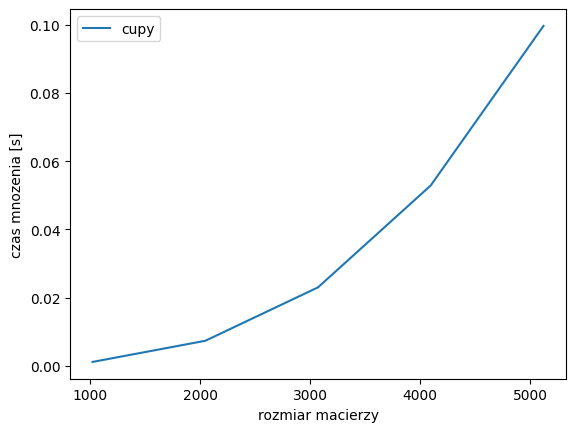

In [2]:
import numpy as np
import cupy as cp
import time
import matplotlib.pyplot as plt

n = [1024, 2048, 3072, 4096, 5120]
times = []

for size in n:
  N = size

  A_cpu = np.random.rand(N, N).astype(np.float32)
  B_cpu = np.random.rand(N, N).astype(np.float32)

  A_gpu = cp.array(A_cpu)
  B_gpu = cp.array(B_cpu)

  start = time.time()
  C_gpu = cp.matmul(A_gpu, B_gpu)
  cp.cuda.Stream.null.synchronize()
  end = time.time()

  times.append(end-start)

  print (f"Mnozenie macierzy na GPU trwalo: {end-start :.5f} sekund.")

plt.plot(n, times, label='cupy')
plt.legend()
plt.xlabel('rozmiar macierzy')
plt.ylabel('czas mnozenia [s]')
plt.show()



Mnozenie macierzy na GPU trwalo: 0.00789 sekund.
Mnozenie macierzy na GPU trwalo: 0.06063 sekund.
Mnozenie macierzy na GPU trwalo: 0.18931 sekund.
Mnozenie macierzy na GPU trwalo: 0.24826 sekund.
Mnozenie macierzy na GPU trwalo: 0.47421 sekund.


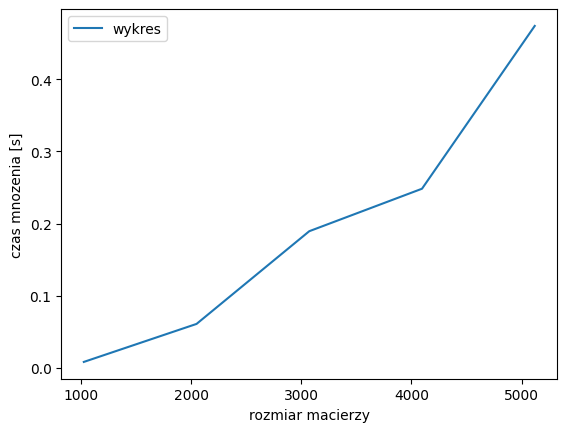

In [20]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import time
import matplotlib.pyplot as plt

kernel_code = """
__global__ void matrixMul ( float *A, float *B, float *C, int N) {
  int row = blockIdx.y * blockDim.y + threadIdx.y;
  int col = blockIdx.x * blockDim.x + threadIdx.x;
  float sum = 0.0;
  if(row < N && col < N) {
    for (int k = 0; k < N; k++) {
      sum += A[ row * N + k] * B[k * N + col ];
    }
    C[ row * N + col] = sum;
  }
}
"""

mod = SourceModule(kernel_code)
matrixMul = mod.get_function("matrixMul")

n = [1024, 2048, 3072, 4096, 5120]
times = []

for size in n:
  N = size

  A_cpu = np.random.rand(N, N).astype(np.float32)
  B_cpu = np.random.rand(N, N).astype(np.float32)
  C_cpu = np.empty((N, N), np.float32)

  A_gpu = cuda.mem_alloc(A_cpu.nbytes)
  B_gpu = cuda.mem_alloc(B_cpu.nbytes)
  C_gpu = cuda.mem_alloc(C_cpu.nbytes)

  cuda.memcpy_htod(A_gpu, A_cpu)
  cuda.memcpy_htod(B_gpu, B_cpu)

  block_size = (32, 32, 1)
  grid_size = (int(N/32), int(N/32), 1)

  start = time.time()

  matrixMul(A_gpu, B_gpu, C_gpu, np.int32(N), block=block_size, grid=grid_size)
  cuda.Context.synchronize()
  cuda.memcpy_dtoh(C_cpu, C_gpu)

  end  = time.time()

  times.append(end-start)

  print(f"Mnozenie macierzy na GPU trwalo: {end-start :.5f} sekund.")

  del A_gpu
  del B_gpu
  del C_gpu


plt.plot(n, times, label='pycuda')
plt.legend()
plt.xlabel('rozmiar macierzy')
plt.ylabel('czas mnozenia [s]')
plt.show()
